<a href="https://colab.research.google.com/github/andrewkallai/MLTSA25_AKallai/blob/main/HW7/Clustering_businesstimeseries_instructions_MLTSA25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series clustering exercise

# Data

The data is on the github repo. It can also be gotten directly from the Census Boureau and from NYC open data.

Each file is the economic census for 1 year.
Download it programmatically and move it to PUIdata

data link https://github.com/fedhere/MLTSA_FBianco/blob/main/data/nyc_zpb_est_1994_2014.csv



make sure yuo read it so that the index column is the zipcode

In [20]:
#Github installations

!pip install PyGithub
!pip install pydub

In [21]:
#all imports go here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors
import scipy.cluster as scp


In [22]:
# read in the business data: this is the number of licenced business per zipcode in NYC from 1994 through 2014
df = pd.read_csv('https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/refs/heads/main/data/nyc_zpb_est_1994_2014.csv', index_col=0)
df.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,57.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,493.0,755.0,772.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,527.0,731.0,752.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,422.0,673.0,696.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1180.0,1687.0,1736.0


In [23]:
#Getting into my google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [24]:
cd /content/gdrive/MyDrive/MLTSA25/HW7

/content/gdrive/MyDrive/MLTSA25/HW7


In [25]:
!ls ..


data  HW3  HW4	HW7


# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check. you should have 21(N_timestamps) datapoints per time series and about 239 zipcodes (Nzipcodes)

- drop all rows with 10 missing values or more
- impute missing values using k nearest neighbors with k=5 (you can use AI prompts to do that)


mydata.shape should be (Nzipcodes, Ntimestamps)



In [26]:
df.shape


(248, 21)

<Axes: >

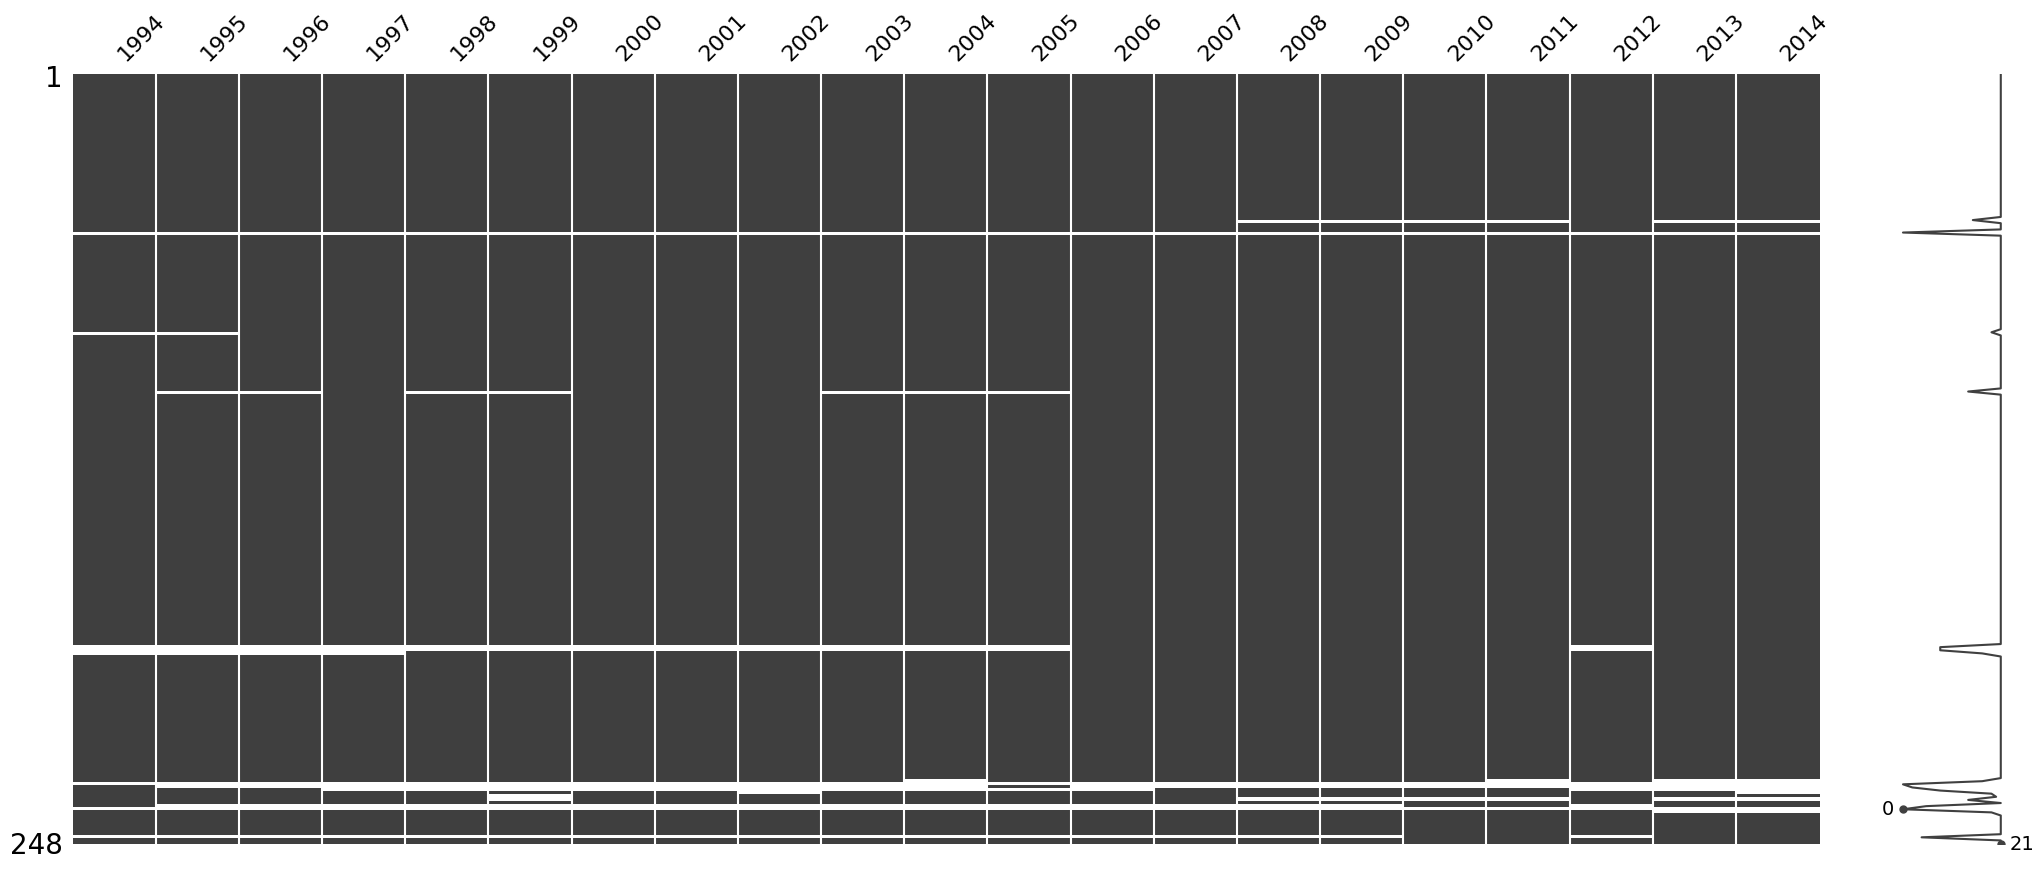

In [27]:
import missingno as mno
mno.matrix(df)

### Figure 1
A structured visual overview of the dataset, with columns displayed along the top horizontal axis and rows listed on the left vertical axis. Missing values are represented as white spaces, offering an intuitive way to identify gaps compared to laborious spreadsheet analysis. The plot reveals that several rows—especially those toward the bottom—are entirely empty, while the majority of other rows are either fully or predominantly populated. This visualization efficiently highlights patterns in data completeness and distribution.

In [28]:
df.dropna(axis = 0, thresh=12, inplace=True)
df.shape

(239, 21)

<Axes: >

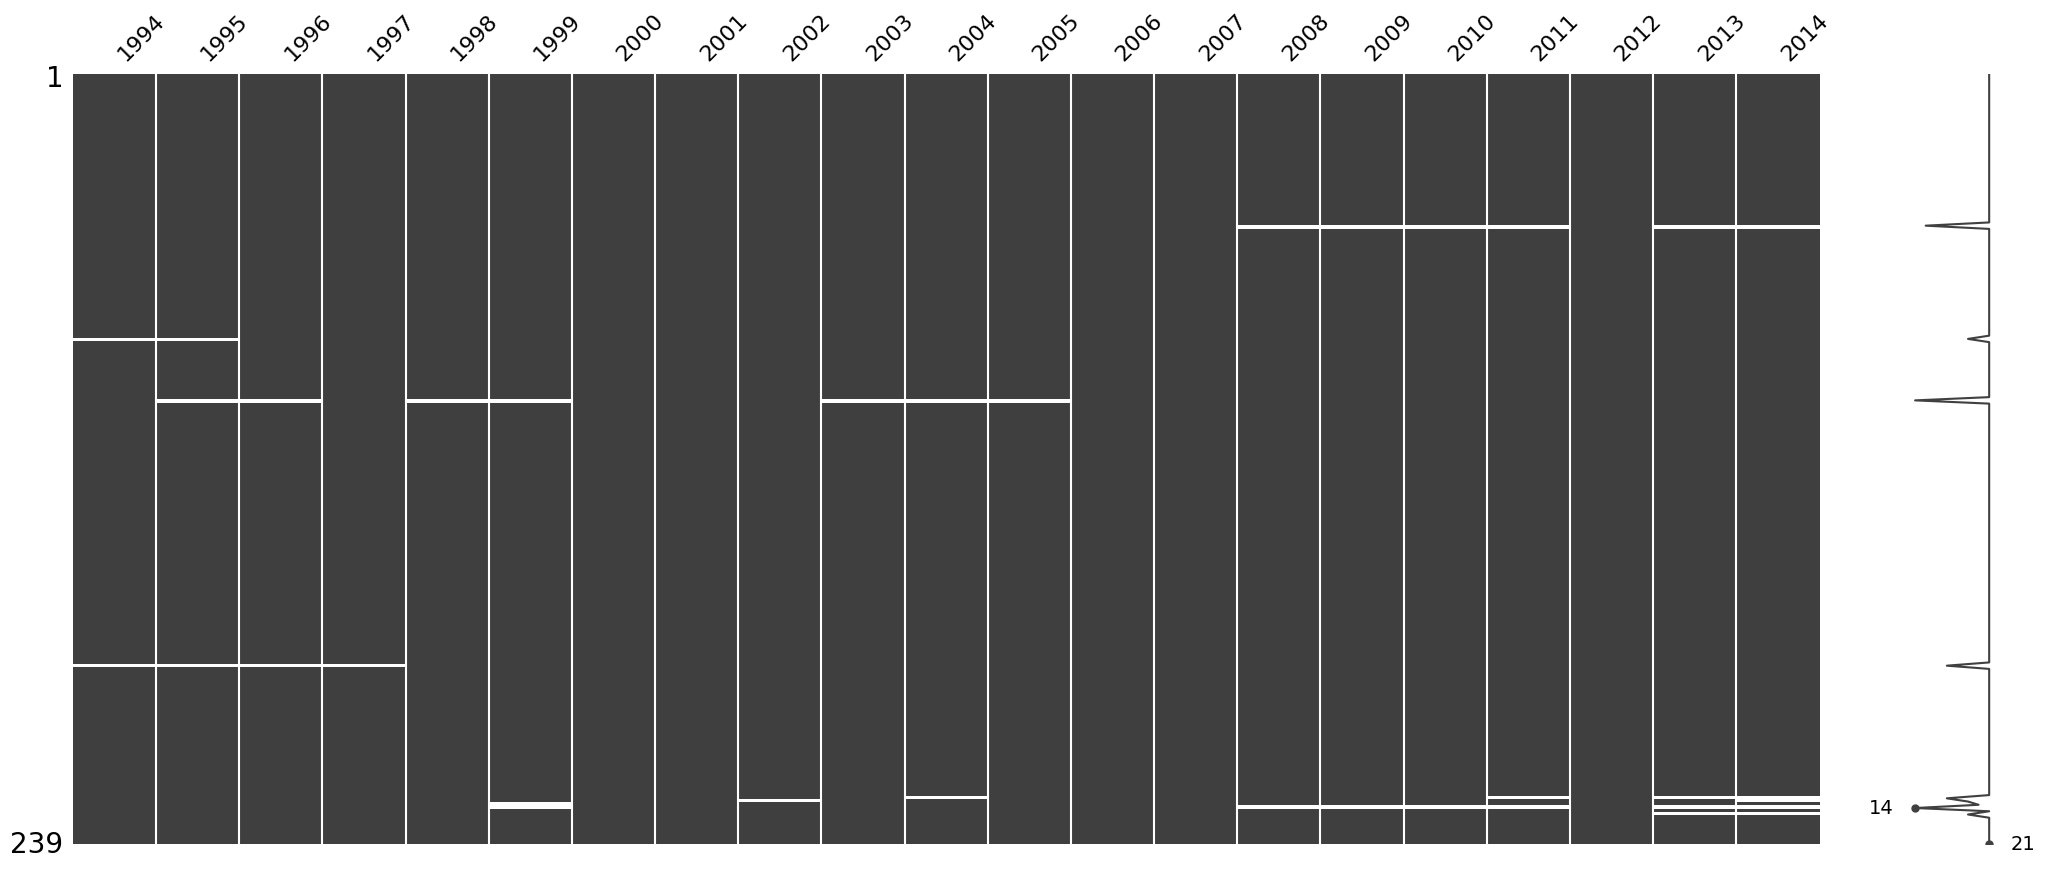

In [29]:

mno.matrix(df)

### Figure 2
Our dataset after dropping all rows with at least 10 missing values. We now have exactly the number of zipcodes we need.

In [30]:

# Initialize KNN imputer with k=5
imputer = KNNImputer(n_neighbors=5)
# Fit and transform the data to impute missing values
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

In [31]:
df_imputed.shape

(239, 21)

<Axes: >

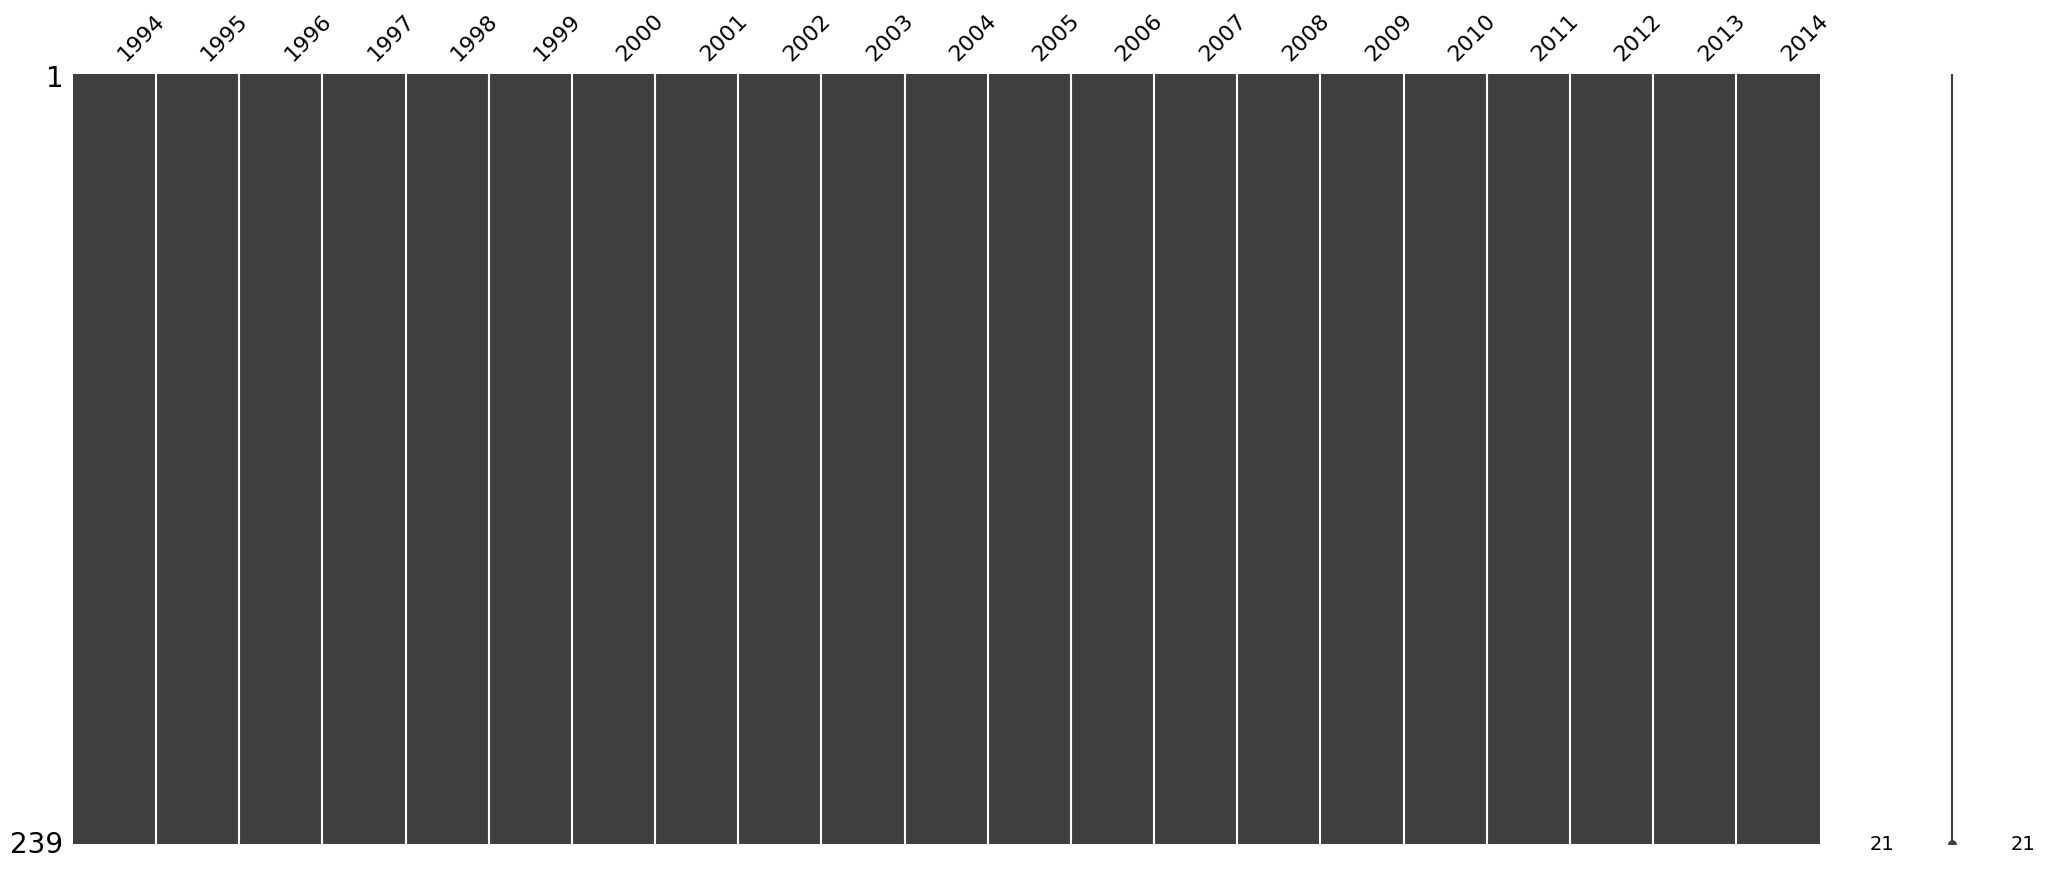

In [32]:
mno.matrix(df_imputed)

### Figure 3
Our dataset after imputing the missing values using K nearest neighbors. Now there are no missing values.

# get the zipcodes shape file
by cloning the repo https://github.com/wimlds/smart_cities.git


In [33]:
!git clone https://github.com/wimlds/smart_cities.git

fatal: destination path 'smart_cities' already exists and is not an empty directory.


Original Data Shape: (263, 13)


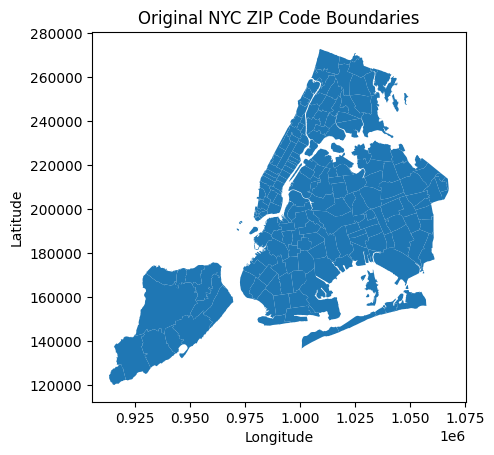

Cleaned Data Shape: (248, 13)


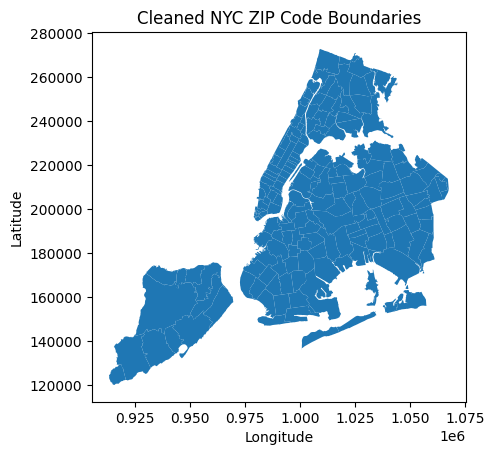

Unique ZIP Codes: 248, Total Polygons: 248
Note: The discrepancy is due to islands with the same ZIP Code as parts of land, but with disjoint shapes.
Total NYC ZIP Codes: 248


In [34]:
#look at the code and the plots below : I am using geopandas to plot maps of zipcodes from a shapefile and I am removing duplicate entries that have the same zipcode

# Load NYC ZIP Code Shapefile
nyc_zip_code_shp = gp.read_file("smart_cities/NYC_shapefiles/ZIP_CODE_040114.zip")

# Display Original Data Information
print("Original Data Shape:", nyc_zip_code_shp.shape)
ax = nyc_zip_code_shp.plot()
ax.set_title("Original NYC ZIP Code Boundaries")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

# Remove Duplicate ZIP Codes
nyc_zip_code_shp = nyc_zip_code_shp.drop_duplicates(subset="ZIPCODE", keep="first")
print("Cleaned Data Shape:", nyc_zip_code_shp.shape)
ax = nyc_zip_code_shp.plot()
ax.set_title("Cleaned NYC ZIP Code Boundaries")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

# Analyze ZIP Code Data
unique_zips = np.unique(nyc_zip_code_shp["ZIPCODE"])
total_polygons = len(nyc_zip_code_shp)
print(f"Unique ZIP Codes: {len(unique_zips)}, Total Polygons: {total_polygons}")
print("Note: The discrepancy is due to islands with the same ZIP Code as parts of land, but with disjoint shapes.")

# Extract and Count NYC ZIP Codes
nyc_zip_codes = nyc_zip_code_shp["ZIPCODE"].values.astype(int)
print(f"Total NYC ZIP Codes: {len(nyc_zip_codes)}")



### Figure 4
Visualizes New York City counties associated with the zip codes in our dataset. The x- and y-axes here are symbolic and do not reflect actual geographic distances, as the map is simplified for illustrative purposes. The upper plot displays all zip code locations from the raw dataset, while the lower plot shows the refined map after removing duplicate entries (locations sharing identical zip codes). Post-deduplication, the lower plot reveals a reduction in visible counties, particularly small offshore islands that were eliminated due to overlapping zip codes with larger mainland counties. This filtering streamlines the visualization, emphasizing spatial distribution patterns.

## TASKS:
    
    1. Scale and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to
    decide what a good number is here. try a few options, keeping in mind
    a few is more than a couple, but i recommand you stay within the
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of
    the clusters). you can plot for example the cluster centers overlayed on
    each time series (using the alpha channel to control the opacity in the
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is
    an exploratory tool so you do not want to jump to conclusions because
    you see some clusters! but seeing structure in your data can inform
    your next moves as an investigator.
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris.
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.*

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dfTransposed = df_imputed.T
scaler.fit(dfTransposed)

scaler.mean_

array([7.44761905e+01, 5.51333333e+02, 5.85428571e+02, 4.86857143e+02,
       1.28552381e+03, 1.01100000e+03, 2.23095238e+03, 8.65809524e+02,
       1.82409524e+03, 1.68838095e+03, 3.91333333e+02, 2.85238095e+02,
       5.86476190e+02, 9.87095238e+02, 9.85095238e+02, 3.16714286e+02,
       1.48619048e+02, 5.98476190e+02, 7.24142857e+02, 9.92142857e+02,
       5.26333333e+02, 9.15285714e+02, 9.77476190e+02, 5.03285714e+02,
       5.45523810e+02, 4.57238095e+02, 1.17271429e+03, 6.72523810e+02,
       4.37571429e+02, 6.86571429e+02, 5.92142857e+02, 4.82428571e+02,
       4.64285714e+02, 5.70047619e+02, 1.31571429e+02, 4.94619048e+02,
       7.25952381e+02, 3.21952381e+02, 2.10952381e+02, 8.24095238e+02,
       6.05238095e+02, 5.83000000e+02, 1.64571429e+02, 1.92561905e+03,
       5.33047619e+02, 2.71714286e+02, 4.68285714e+02, 5.87133333e+02,
       1.85004762e+03, 8.72238095e+02, 7.96285714e+02, 6.25190476e+02,
       6.38095238e+00, 3.50285714e+02, 8.38619048e+02, 1.63909524e+03,
      

In [36]:
vals = scaler.transform(dfTransposed).T
vals.shape
vals.mean(axis=1), vals.mean(axis=1).shape

(array([-2.85485921e-16, -3.38353684e-16, -2.11471052e-16,  3.38353684e-16,
        -4.86383420e-16, -2.11471052e-17,  6.66133815e-16, -4.75809868e-16,
         1.16309079e-16,  4.01794999e-16,  8.24737104e-16, -3.38353684e-16,
        -3.17206578e-16,  3.38353684e-16,  4.86383420e-16, -2.32618158e-16,
        -2.85485921e-16, -7.40148683e-17,  5.07530526e-16,  7.61295788e-16,
        -8.88178420e-16, -8.56457762e-16, -1.05735526e-16,  2.11471052e-16,
         1.48029737e-16, -6.34413157e-17, -1.20538500e-15,  8.45884209e-17,
         2.53765263e-16,  2.43191710e-16,  3.91221447e-16, -1.79750394e-16,
         2.11471052e-16,  1.16309079e-16, -3.27780131e-16,  6.34413157e-16,
        -2.32618158e-16, -4.01794999e-16, -4.01794999e-16,  2.74912368e-16,
         9.72766841e-16,  9.51619735e-17, -4.22942105e-16, -9.04038749e-16,
         2.32618158e-16, -6.34413157e-17,  1.05735526e-16,  8.98751972e-17,
         3.17206578e-17,  9.72766841e-16, -3.48927236e-16,  5.18104078e-16,
        -1.7

In [37]:
vals.std(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (248,)

vals.std(axis=1) should return 1 everywhere



# KM Clustering

In [38]:
vals.mean(axis = 0).shape

(21,)

create a kmeans model with 5 clusters

In [39]:
nc = 5
km = KMeans(n_clusters=nc, random_state=302).fit(vals)


In [40]:
km.cluster_centers_[0].shape

(21,)

### Plot and map the clusters.

First reflect on this: the center of a cluster is a point within the cluster. If your cluster is a cluster of time series its center is... A TIME SERIES! so your cluster centers should be time series of 21 points (1995-2015)

The cluster centers are extracted as km.center

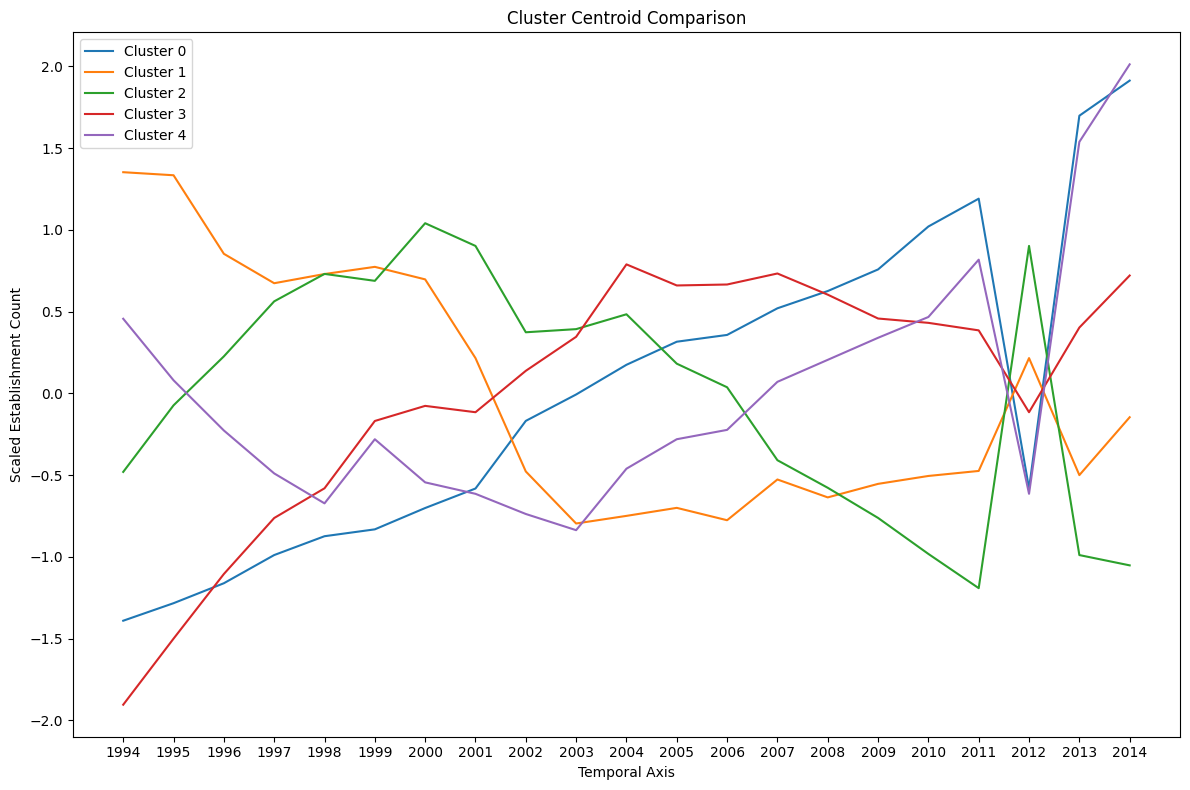

In [41]:
# Visualize Cluster Centroids
fig, ax = plt.subplots(figsize=(12, 8))
for cluster_id, centroid in enumerate(km.cluster_centers_):
    ax.plot(df_imputed.columns, centroid, label=f'Cluster {cluster_id}')
ax.set_xlabel('Temporal Axis')
ax.set_ylabel('Scaled Establishment Count')
ax.set_title('Cluster Centroid Comparison')
ax.legend()
plt.tight_layout()
plt.show()


### Figure 5
Visualizes the cluster centroids generated by the kMeans model. Each time series exhibits distinct patterns and trajectories, with minimal overlap between clusters. A notable anomaly occurs around 2012, where several series display sharp upward or downward spikes. This abrupt divergence may correlate with broader economic shifts or sector-specific events during that period, potentially reflecting systemic disruptions that impacted business performance (e.g., rapid growth for some entities and collapse for others). The temporal irregularity underscores the value of contextual analysis when interpreting cluster behavior over time.

In [42]:
#plot just the centers here
km.cluster_centers_.shape


(5, 21)

Then plot also the time series that belong to the cluster, overplotting them on the cluster center (cluster center in blue, alpha=1, time series in black, alpha=0.3). The time series in a cluster can be found as km.labe

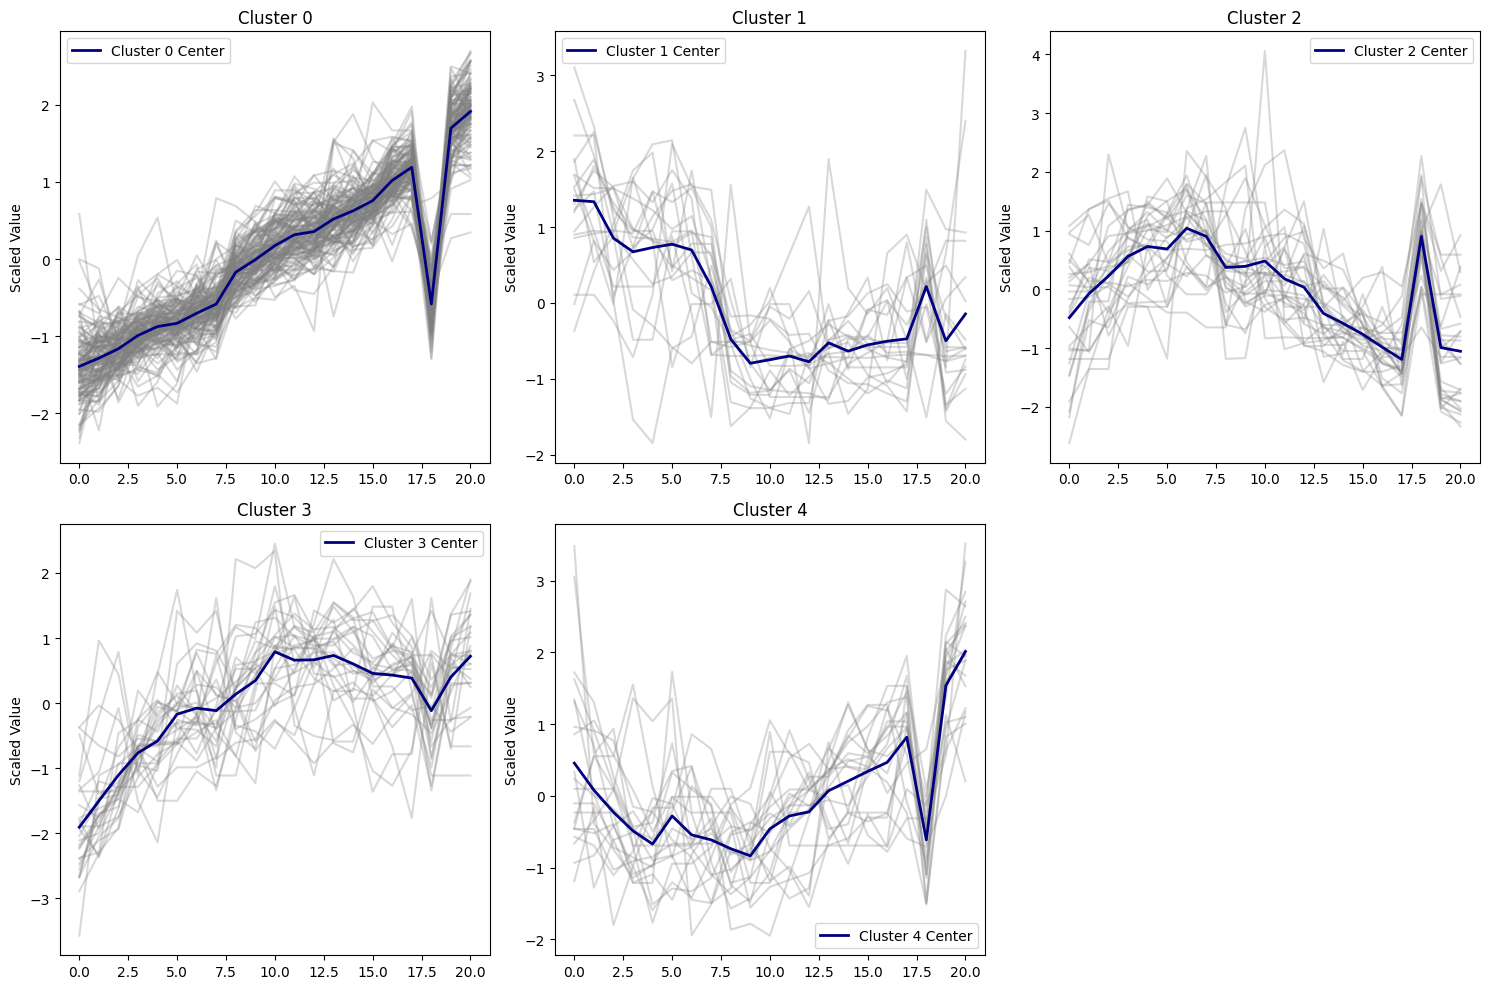

In [44]:

# Visualize Clusters and Centroids
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust subplot grid as needed

for i, ax in enumerate(axs.flat):
    if i >= nc:
        ax.axis('off')  # Hide unused subplots
        continue

    # Extract and plot cluster data
    cluster_mask = km.labels_ == i
    cluster_timeseries = vals[cluster_mask, :]

    for ts in cluster_timeseries:
        ax.plot(ts, color='gray', alpha=0.3, label=None)  # Removed label for individual timeseries

    # Plot cluster centroid
    ax.plot(km.cluster_centers_[i], color='navy', linewidth=2, label=f'Cluster {i} Center', alpha=1)

    ax.set_ylabel('Scaled Value')
    ax.set_title(f'Cluster {i}')
    ax.legend()

plt.tight_layout()
plt.show()


### Figure 6
Displays the five clusters identified by the kMeans algorithm, with cluster centroids highlighted in blue. A notable contrast emerges: Cluster 0 exhibits the highest density, suggesting a significant cohort of businesses followed highly uniform growth trajectories across multiple zip codes. In contrast, the remaining clusters demonstrate greater sensitivity to noise, with member time series distributed more diffusely around their centroids. This dispersion implies variability in growth patterns or external influences affecting businesses within these clusters, underscoring the heterogeneity of trends captured by the model. The visualization emphasizes the dominance of Cluster 0’s spatial and temporal consistency compared to the fragmented nature of other groupings.

In [45]:
km.cluster_centers_[0].shape

(21,)

Map the zipcodes by color according to the cluster center - you can make a single map in 5 color or 5 maps in 1 color each


In [46]:
#create a dataframe with the cluster id per zipcode
clustersdf = pd.DataFrame()
clustersdf['ZIPCODE'] = df_imputed.index.astype(str)
clustersdf['cluster'] = km.labels_
clustersdf.head()

,ZIPCODE,cluster
0,11436,0
1,11213,0
2,11212,0
3,11225,0
4,11218,0


In [49]:
#merge it with the geodataframe with the zipcode shapes- I am losing 1 zipcode...
mergednyz = nyc_zip_code_shp.merge(clustersdf, on='ZIPCODE', how='inner')
print("length of dataframes:",
      len(mergednyz.ZIPCODE),
      len(np.unique(clustersdf.ZIPCODE)), len(np.unique(nyc_zip_code_shp.ZIPCODE)))

length of dataframes: 239 239 248


<ipython-input-50-f928b1633c5b>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['' * len(ax.get_xticklabels())])
<ipython-input-50-f928b1633c5b>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['' * len(ax.get_xticklabels())])
<ipython-input-50-f928b1633c5b>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['' * len(ax.get_xticklabels())])
<ipython-input-50-f928b1633c5b>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['' * len(ax.get_xticklabels())])
<ipython-input-50-f928b1633c5b>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. aft

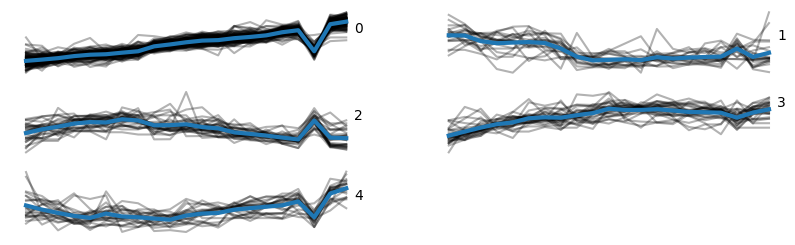

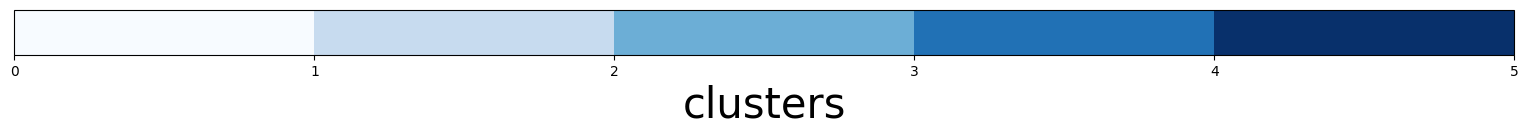

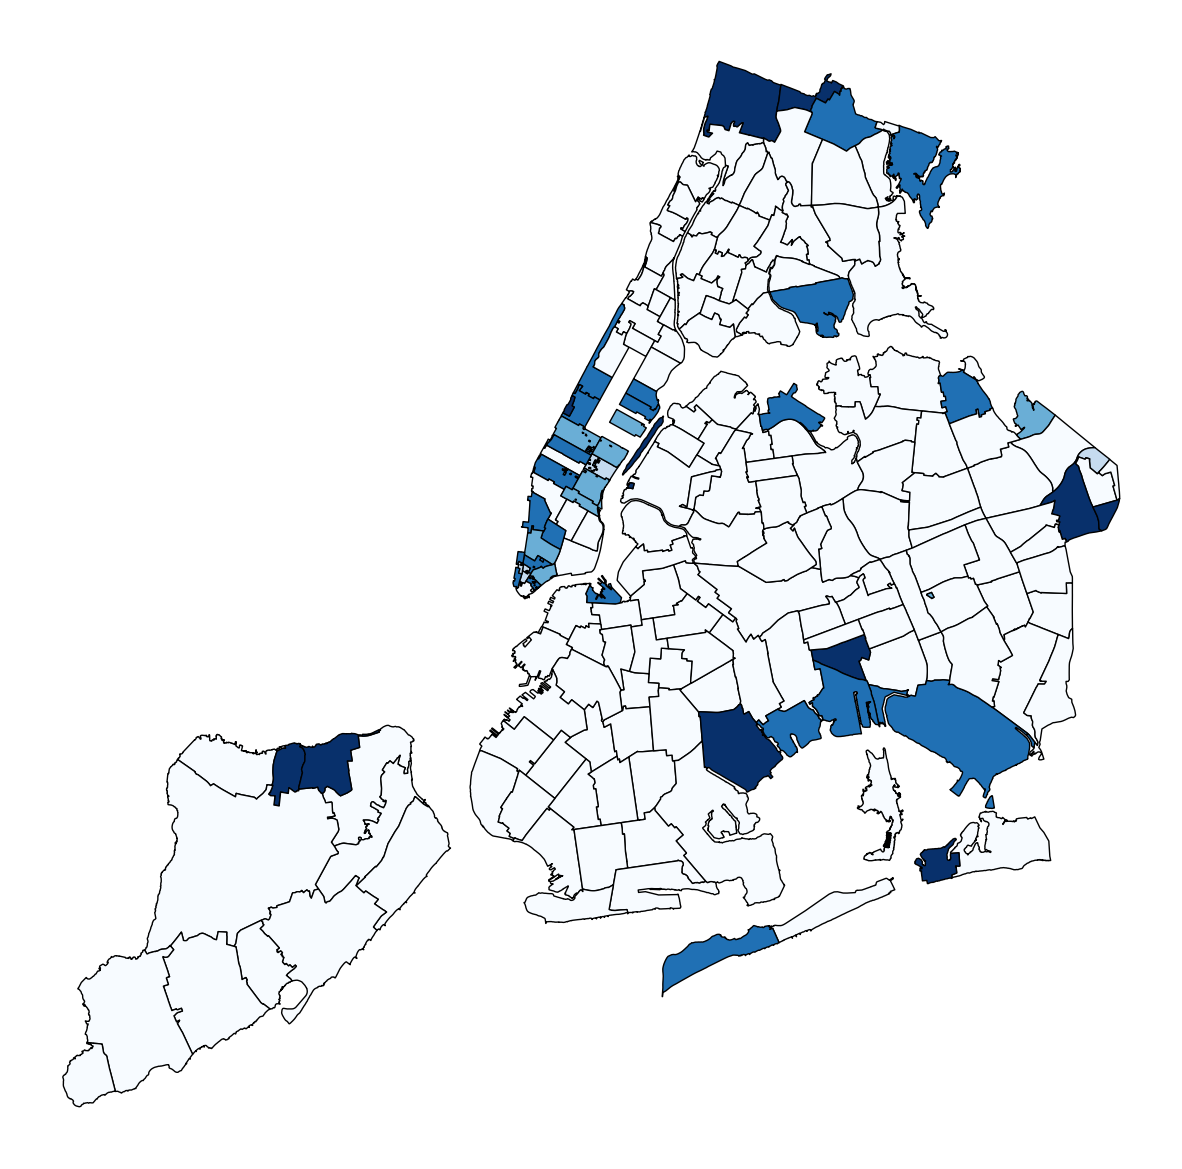

In [50]:
import matplotlib as mpl
fig = plt.figure(figsize=(10, 5))
for i, Xc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(5, 2, (i + 1))

    for v in vals[km.labels_ == i]:
        ax.plot(np.arange(1994, 2015, 1), v, 'k-', alpha=0.3)
    ax.text(2014.5, 1, "%d" % i)

    plt.xticks(fontsize=10)
    ax.set_yticklabels(['' * len(ax.get_xticklabels())])
    ax.plot(np.arange(1994, 2015, 1), Xc, lw=3)
    plt.grid(False)
    plt.axis('off')
fig = plt.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map
# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.
bounds = range(nc + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(
    ax1,
    cmap=cmap,
    norm=norm,
    ticks=bounds,
    spacing='uniform',
    orientation='horizontal')
cb3.set_label('clusters', fontsize=30)
ax = plt.figure(figsize=(15, 15)).add_subplot(111)
mergednyz.plot(column='cluster', cmap='Blues', alpha=1, ax=ax, ec='k')
tmp = ax.axis('off')

### Figure 7 contrasts two visualizations:  
- Top: The five kMeans clusters with centroids outlined in blue.  
- Bottom: A geographic map of NYC zip codes, color-coded by cluster membership.  

The map highlights a disproportionate representation of Cluster 0 (aligned with its dense time series grouping in the top plot), suggesting widespread similarity in business growth trends across numerous zip codes. This spatial homogeneity raises questions about the model’s suitability, as such uniformity across diverse geographic regions is statistically unexpected. The kMeans algorithm’s sensitivity to noise or inherent bias toward overgrouping may explain this pattern, implying that alternative clustering methods or data preprocessing could better capture meaningful distinctions in the dataset.

cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

Can you parse some business and socioeconomic dynamics from this plot?

create 8 kmeans models with 2-10 cluster centers. put each model in a list

(array([0, 1], dtype=int32), array([183,  56]))
(array([0, 1, 2], dtype=int32), array([180,  26,  33]))
(array([0, 1, 2, 3], dtype=int32), array([150,  26,  32,  31]))
(array([0, 1, 2, 3, 4], dtype=int32), array([142,  19,  29,  28,  21]))
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([142,  20,  25,   7,  21,  24]))
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([138,  20,  22,   9,  17,  25,   8]))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([136,  22,  14,  13,  10,  17,  19,   8]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32), array([96, 22, 13, 12, 10, 11, 16,  8, 51]))


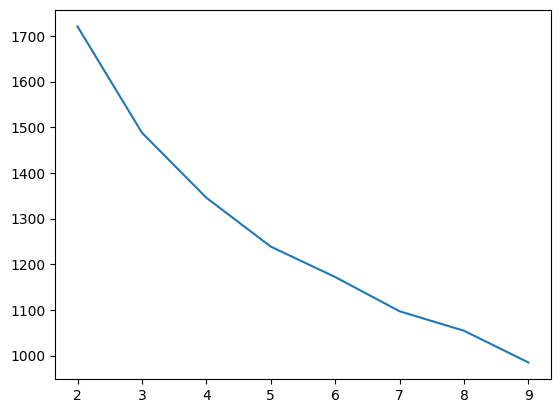

In [51]:
kms = []
for nc in range(2,10):
  #cluster with kmeans
  kms.append(KMeans(n_clusters=nc, random_state=302).fit(vals))
#each observation in the km object has a label:
#that is the cluster assigned to that observation
for km in kms:
  print(np.unique(km.labels_, return_counts=True))
import pylab as plt
plt.plot(range(2,10), [km.inertia_ for km in kms])

### Figure 8:  
Question: Was the choice of 5 clusters empirically justified?  

The inertia plot (not shown here) lacks a definitive "elbow," making the optimal cluster count ambiguous. While a rough elbow-like bend near 6 clusters might suggest this as a provisional value for KMeans, this interpretation remains subjective. Notably, a subsequent DBSCAN analysis identified just 2 clusters, starkly contrasting with the KMeans result. This discrepancy highlights potential overpartitioning by KMeans or undersensitivity in DBSCAN, depending on data structure and hyperparameters. The tension between these outcomes implies that 5 cluster—midway between the two—may lack strong empirical grounding. A simpler model (e.g., fewer clusters) or alternative algorithms (e.g., hierarchical clustering) could better align with the data’s inherent patterns, emphasizing the need for methodological robustness against algorithmic bias.

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

# repeating the exercise using DBSCAN or hyerarchical agglomerative clustring...

2


<ipython-input-53-31c508f5c625>:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


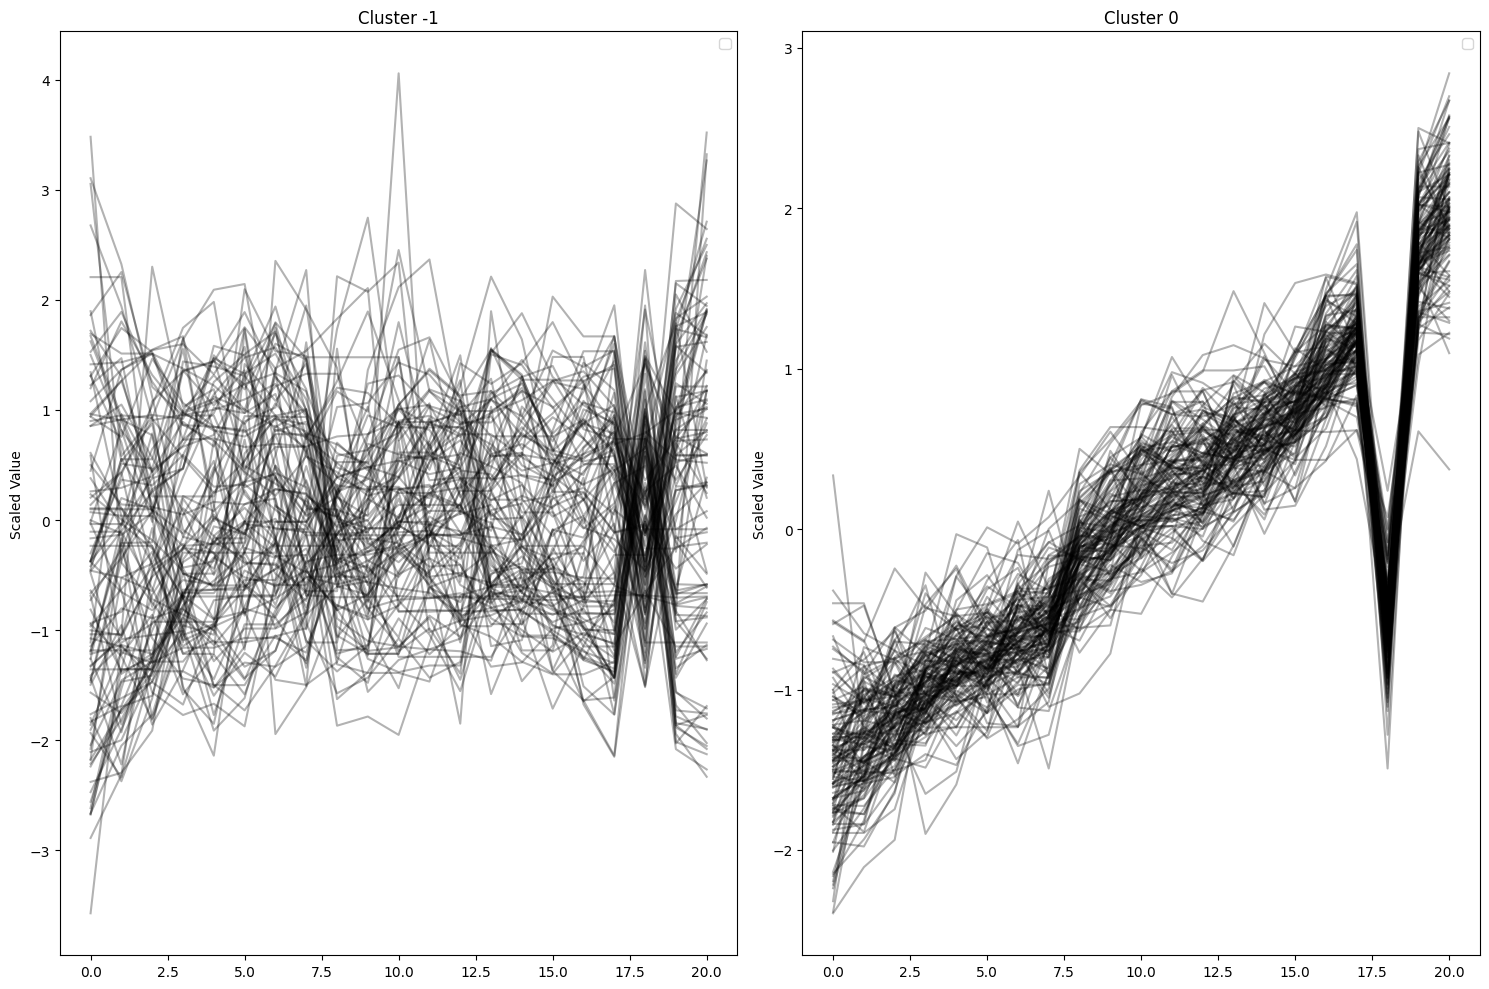

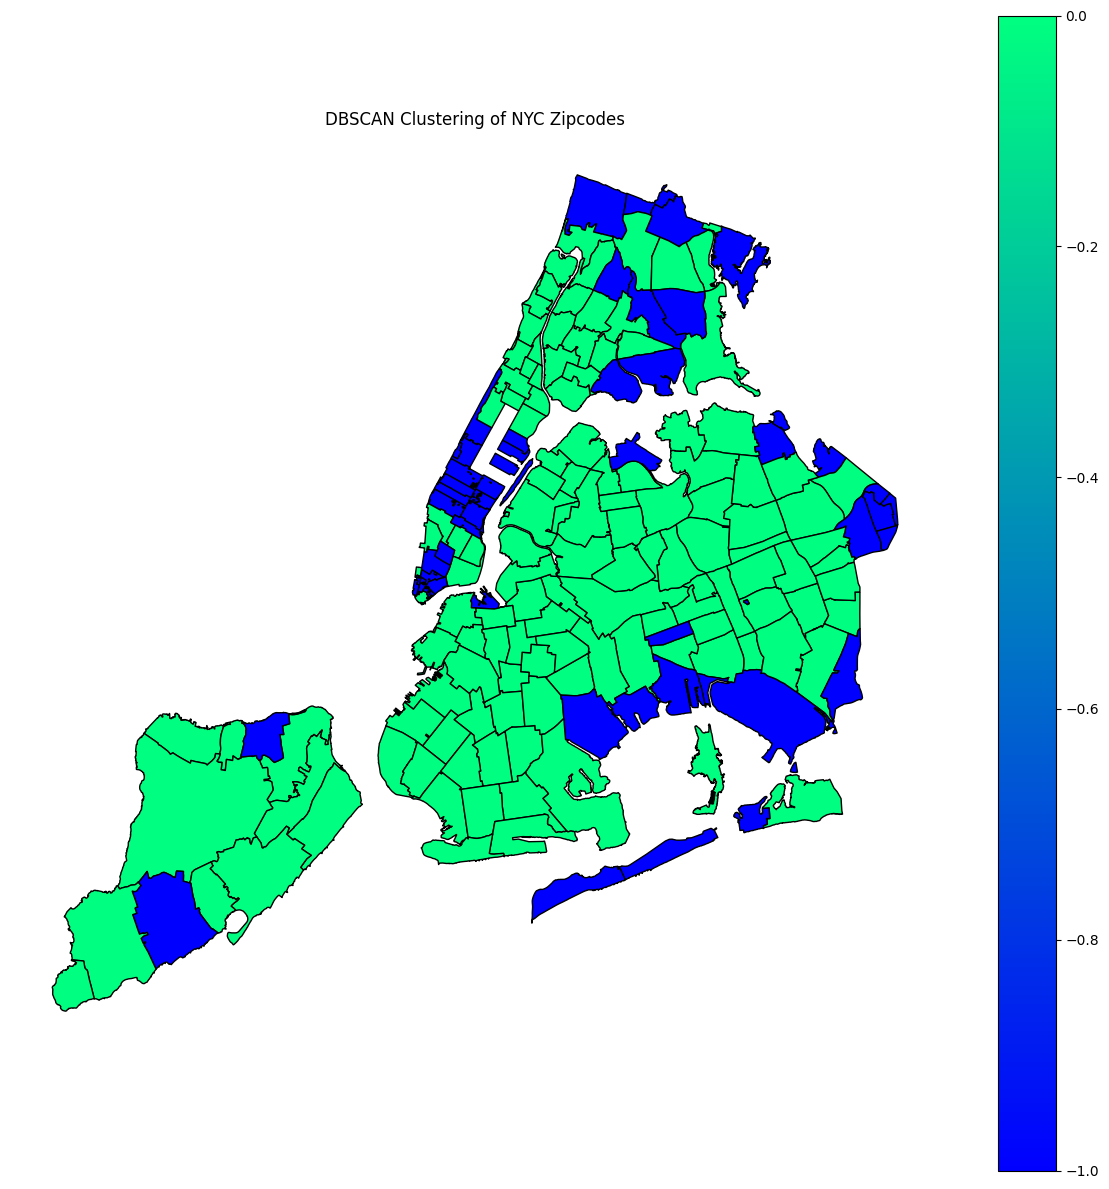

Number of KMeans clusters: 9
Number of DBSCAN clusters: 2


In [53]:


dbscan = DBSCAN(eps=1.5, min_samples=7).fit(vals)
dbscan.labels_

plt.figure(figsize=(15, 10))
cluster_labels = np.unique(dbscan.labels_)
nc = len(cluster_labels)

num_rows = (nc // 3) + (nc % 3 > 0)
num_cols = min(3, nc)
subplot_index = 1
print(nc)
for i in cluster_labels:
    plt.subplot(num_rows, num_cols, subplot_index)
    cluster_indices = np.where(dbscan.labels_ == i)[0]
    cluster_data = vals[cluster_indices, :]

    for ts in cluster_data:
        plt.plot(ts, color='black', alpha=0.3)

    plt.ylabel('Scaled Value')
    plt.title(f'Cluster {i}')
    plt.legend()
    subplot_index += 1

plt.tight_layout()
plt.show()


clustersdf_dbscan = pd.DataFrame()
clustersdf_dbscan['ZIPCODE'] = df_imputed.index.astype(str)
clustersdf_dbscan['cluster'] = dbscan.labels_

mergednyz_dbscan = nyc_zip_code_shp.merge(clustersdf_dbscan, on='ZIPCODE', how='inner')

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
mergednyz_dbscan.plot(column='cluster', cmap='winter', alpha=1, ax=ax, legend=True, ec='k')
ax.axis('off')
plt.title("DBSCAN Clustering of NYC Zipcodes")
plt.show()

print("Number of KMeans clusters:", len(np.unique(km.labels_)))
print("Number of DBSCAN clusters:", len(np.unique(dbscan.labels_)))


### Figure 9  
Visualization: A geographic map of NYC zip codes, color-coded by the two clusters identified via DBSCAN. The cluster distribution (plotted above the map) excludes centroids, as DBSCAN is a density-based algorithm that does not rely on central points.  

Key Observations:  
- The colormap aligns partially with the earlier K-Means results, where dark blue likely denotes noise points (formally labeled as cluster -1 in DBSCAN).  
- The 2012 anomaly—previously noted in K-Means clusters—remains pronounced here, suggesting this temporal event strongly influenced clustering outcomes across methodologies.  

Implications:  
The persistence of the 2012 signal across both K-Means and DBSCAN models underscores its systemic impact on business trends. To validate causality, further investigation into 2012-specific economic, regulatory, or environmental shifts is critical. This step could disentangle whether the anomaly reflects data artifacts (e.g., reporting changes) or genuine market disruptions. The consistency across algorithms also highlights the value of multi-method analysis to isolate robust patterns from methodological noise.

##Comparison and Interpretation

Both algorithms yield similar results in regards to which zipcode is placed in which cluster. Thus there may be some reason as to why both clustering algorithms behaved this way, it may not be just noise. It may be worth doing some domain research to figure out what business tend to frequent these clusters as that may help to identify other similarities between the zipcodes of that cluster. Additionally, we have seen that the event in 2012 has affected both clustering algorithms, so further research should be done to identify that event.

We determined from our study of kMeans clustering that 5 clusters may not be optimal for this dataset. The DBSCAN model maintains the same separation between zipcodes as in the kMeans case, but with fewer (2) clusters. This means that we could conduct further studies of 3 and 4 clusters to see if those numbers may be more appropriate.

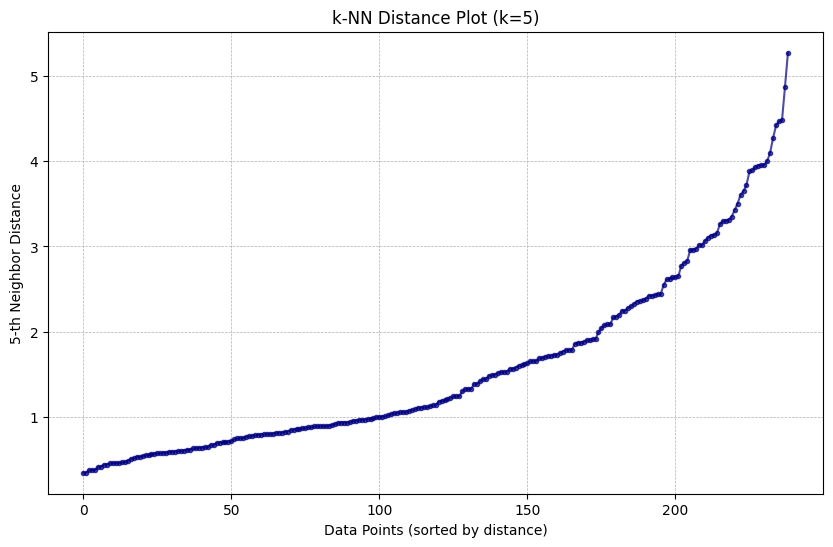

In [63]:


def plot_kth_neighbor_distance(dataset, k_neighbors=5):
    """
    Visualizes the k-th nearest neighbor distance plot to facilitate the selection of an optimal epsilon value for DBSCAN.

    Parameters:
        dataset (np.ndarray): Input data for the analysis.
        k_neighbors (int, optional): Number of neighboring points to consider (defaults to 5).
    """
    # Initialize and fit the nearest neighbors model
    nearest_neighbors_model = NearestNeighbors(n_neighbors=k_neighbors)
    nearest_neighbors_model.fit(dataset)

    # Compute distances to k-th nearest neighbors
    distances_to_neighbors, _ = nearest_neighbors_model.kneighbors(dataset)

    # Extract and sort k-th nearest neighbor distances
    kth_distances = np.sort(distances_to_neighbors, axis=0)[:, 1]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(kth_distances, marker='.', linestyle='-', color='navy', alpha=0.7)
    plt.xlabel("Data Points (sorted by distance)")
    plt.ylabel(f"{k_neighbors}-th Neighbor Distance")
    plt.title(f"k-NN Distance Plot (k={k_neighbors})")
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Example usage (assuming 'vals' is your dataset):
plot_kth_neighbor_distance(vals, k_neighbors=5)


### Figure 10:
The k distance plot helps confirm this optimal choice of clusters and the epsilon parameter for DBSCAN. The elbow point, where the curve sharply rises (around y ≈ 2.5–3), is a good eps parameter in DBSCAN.


# If you want to use agglomerative clustering

In [ ]:
#

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

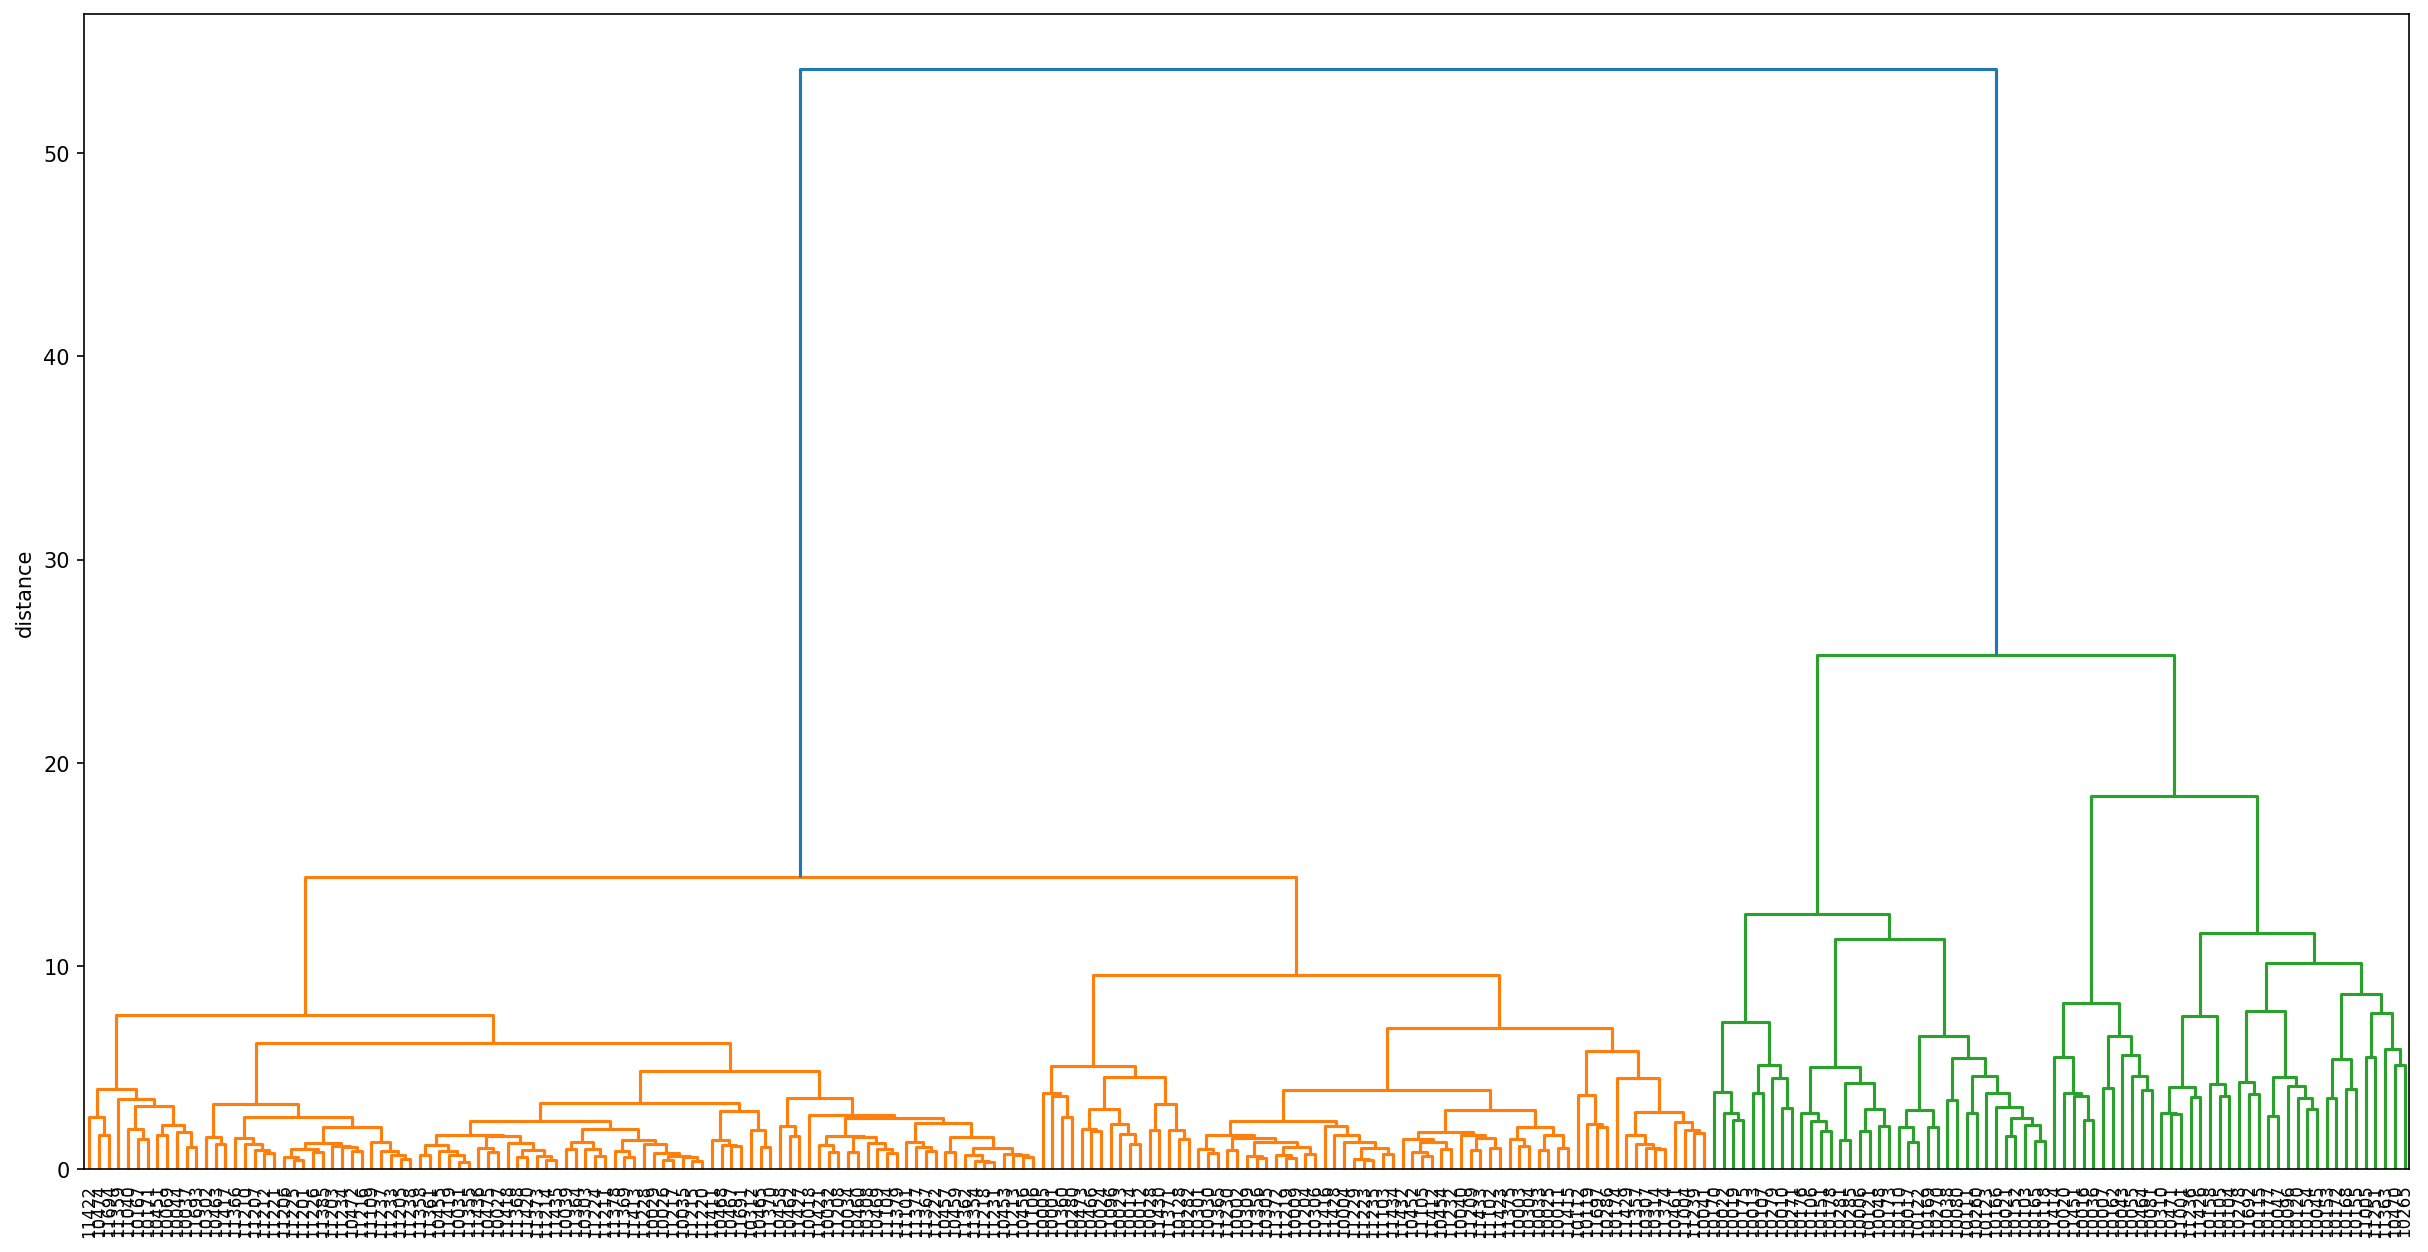

In [61]:

fig = plt.figure(figsize=(20,10), dpi=150)
plt.ylabel("distance")
zipcodes = df_imputed.index.astype(str).tolist()
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = zipcodes,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)


### Figure 11
This dendrogram shows a visual representation of the zipcodes and how they have been clustered. The two large cluster centers are obvious here.

In [62]:
!pwd

/content/gdrive/MyDrive/MLTSA25/HW7
